### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра информационных технологий 

## ОТЧЕТ ПО ЛАБОРАТОРНОЙ РАБОТЕ № 5


### Дисциплина: Методы машинного обучения

##### Студент:  Шалыгин Георгий
##### Группа:   НФИ-02

## Москва 2023
***

### Вариант № 15

1. При помощи модуля pandas_datareader считайте котировки указанной в индивидуальным задании акции за указанный период времени.

Считайте котировки акции с указанным ниже тикером за 2018-2019 год: 

 KO      Coca-Cola Company 

In [ ]:
#!pip install yfinance

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
tf.__version__

'2.12.0'

In [2]:
from pandas_datareader import data as pdr
import yfinance as yfin
import datetime as dt

yfin.pdr_override()

In [3]:
aapl = pdr.get_data_yahoo('KO', 
                          start=dt.datetime(2018, 1, 1), 
                          end=dt.datetime(2019, 1, 1))
aapl.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,45.910000,45.939999,45.509998,45.540001,38.548206,10872200
2018-01-03,45.490002,45.689999,45.340000,45.439999,38.463558,12635600
2018-01-04,45.560001,46.220001,45.450001,46.080002,39.005295,12709400
2018-01-05,46.020000,46.200001,45.790001,46.070000,38.996834,13113100
2018-01-08,45.950001,46.099998,45.880001,46.000000,38.937584,7068600


In [4]:
aapl.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-24,47.619999,47.869999,45.830002,45.959999,40.249268,10733700
2018-12-26,45.880001,46.959999,45.660000,46.939999,41.107498,14342600
2018-12-27,46.740002,47.549999,46.029999,47.529999,41.624199,16966500
2018-12-28,47.889999,48.009998,47.029999,47.200001,41.335190,13218200
2018-12-31,47.490002,47.540001,46.959999,47.349998,41.466545,10576300



2. Визуализируйте котировки акции (столбец `Adj Close`) за весь период на графике. Подпишите оси и рисунок.


Text(0.5, 1.0, 'Котировки акций cocacola')

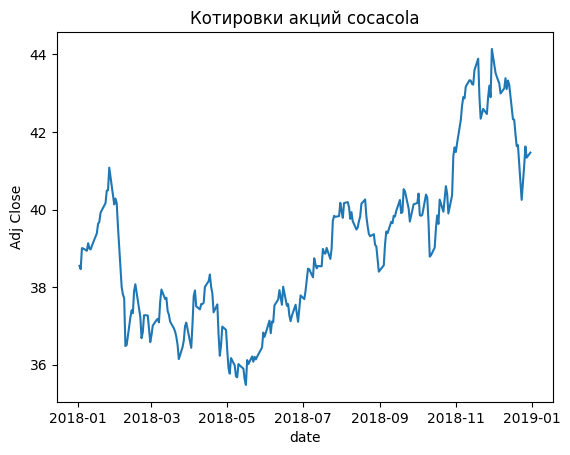

In [6]:
data = aapl['Adj Close']
plt.plot(data)
plt.xlabel('date')
plt.ylabel('Adj Close')
plt.title('Котировки акций cocacola')

3. Вычислите и визуализируйте заданный показатель акции в соответствии с индивидуальным заданием.

Показатель акции: дневной убыток, способ визуализации – диаграмма размаха  

<Axes: title={'center': 'Дневной убыток'}>

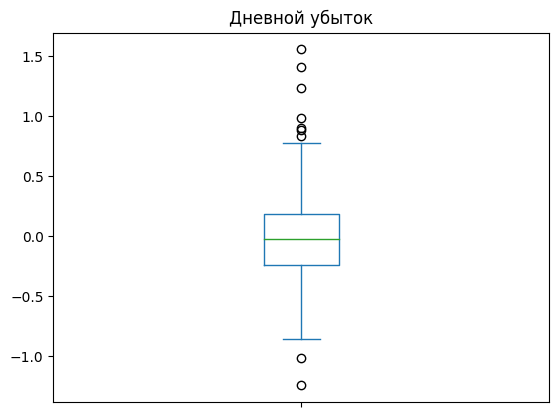

In [7]:
diff = np.append(np.array(data), 0) - np.insert(np.array(data), 0, [0])
diff *= -1
diff = diff[1:-1]
pd.Series(diff).plot.box(title='Дневной убыток')

4. Сформируйте обучающую, тестовую и валидационные выборки для обучения нейронной сети в соответствии с индивидуальным заданием. 

 Прогнозирование стоимости акции через 12 дней по данным за предыдущие 25 дней.

In [8]:
adj = aapl['Adj Close']
raw_data = aapl.drop(['Adj Close'], axis=1)

In [9]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 125
num_val_samples: 62
num_test_samples: 64


In [10]:
# mean = raw_data[:num_train_samples].mean(axis=0)
# raw_data -= mean
# std = raw_data[:num_train_samples].std(axis=0)
# raw_data /= std # whole raw_data normalized w.r.t. first num_train_samples rows

# mean.shape, std.shape

In [11]:
sampling_rate = 1
sequence_length = 25
delay = 25 + 12 - 1
batch_size = 256

train_dataset = tf.keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=adj[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = tf.keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=adj[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = tf.keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=adj[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

5. Постройте нейронную сеть MLP с нормализующим слоем и одним плотным скрытым слоем из 16 нейронов для прогнозирования стоимости акции и обучите ее на обучающей выборке. Оцените качество прогнозирования при помощи заданного показателя качества на тестовой выборке.

 Показатель качества MAE

In [12]:
df_normalizer = tf.keras.layers.Normalization()
df_normalizer.adapt(raw_data)
print(df_normalizer.mean.numpy())
print(df_normalizer.variance.numpy())

[[4.5413548e+01 4.5724541e+01 4.5099438e+01 4.5409920e+01 1.2525482e+07]]
[[4.4421110e+00 4.5318952e+00 4.3046637e+00 4.4931951e+00 1.7014095e+13]]


In [90]:
inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = df_normalizer(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(16, activation="relu")(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(0.1), loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                   ) 

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 25, 5)]           0         
                                                                 
 normalization (Normalizatio  (None, 25, 5)            11        
 n)                                                              
                                                                 
 flatten_10 (Flatten)        (None, 125)               0         
                                                                 
 dense_41 (Dense)            (None, 16)                2016      
                                                                 
 dense_42 (Dense)            (None, 1)                 17        
                                                                 
Total params: 2,044
Trainable params: 2,033
Non-trainable params: 11
_______________________________________________________

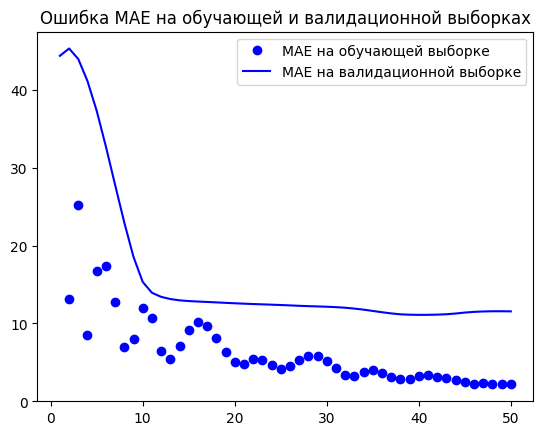

In [91]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs[1:], loss[1:], "bo", label="MAE на обучающей выборке")
plt.plot(epochs, val_loss, "b", label="MAE на валидационной выборке")
plt.title("Ошибка MAE на обучающей и валидационной выборках")
plt.legend()
plt.show()

6. Примените указанную в индивидуальном задании технику решения проблемы исчезающих градиентов и постройте нейронную сеть MLP с нормализующим слоем и тремя плотными скрытыми слоями из 16 нейронов для прогнозирования стоимости акции и обучите ее на обучающей выборке. Оцените качество прогнозирования при помощи заданного показателя качества для тестовой выборки.

 Техника борьбы с исчезающими градиентами: Функции активации без насыщения 

In [92]:
inputs2 = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x2 = tf.keras.layers.Flatten()(inputs2)
x2 = tf.keras.layers.Dense(16, activation="selu")(x2)
x2 = tf.keras.layers.Dense(16, activation="selu")(x2)
x2 = tf.keras.layers.Dense(16, activation="selu")(x2)
outputs2 = tf.keras.layers.Dense(1)(x2)
model2 = tf.keras.Model(inputs2, outputs2)
model2.summary()

model2.compile(optimizer=tf.keras.optimizers.Adam(0.08), loss="mse", metrics=["mae"])
history2 = model2.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                   ) 

print(f"Test MAE: {model2.evaluate(test_dataset)[1]:.2f}")

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 25, 5)]           0         
                                                                 
 flatten_11 (Flatten)        (None, 125)               0         
                                                                 
 dense_43 (Dense)            (None, 16)                2016      
                                                                 
 dense_44 (Dense)            (None, 16)                272       
                                                                 
 dense_45 (Dense)            (None, 16)                272       
                                                                 
 dense_46 (Dense)            (None, 1)                 17        
                                                                 
Total params: 2,577
Trainable params: 2,577
Non-trainable 

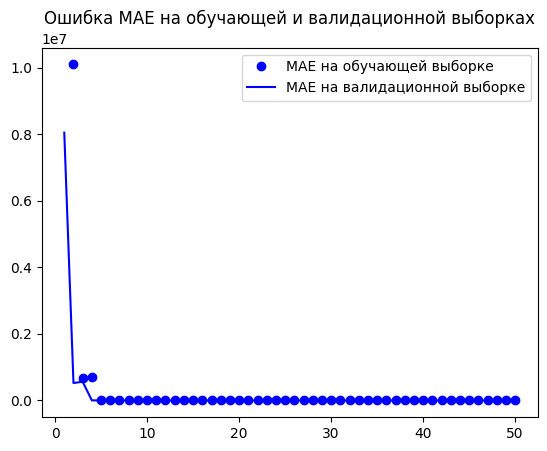

In [93]:
loss = history2.history["mae"]
val_loss = history2.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs[1:], loss[1:], "bo", label="MAE на обучающей выборке")
plt.plot(epochs, val_loss, "b", label="MAE на валидационной выборке")
plt.title("Ошибка MAE на обучающей и валидационной выборках")
plt.legend()
plt.show()

7. Постройте рекуррентную нейронную сеть с нормализующим слоем и одним скрытым слоем LSTM из 16 нейронов для прогнозирования стоимости акции и обучите ее на обучающей выборке. Оцените качество прогнозирования при помощи заданного показателя качества на тестовой выборке.

In [94]:
inputs3 = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x3 = df_normalizer(inputs3)
x3 = tf.keras.layers.LSTM(16)(x3)
outputs3 = tf.keras.layers.Dense(1)(x3)
model3 = tf.keras.Model(inputs3, outputs3)

model3.summary()
model3.compile(optimizer=tf.keras.optimizers.Adam(0.06), loss="mse", metrics=["mae"])
history3 = model3.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                   ) 

print(f"Test MAE: {model3.evaluate(test_dataset)[1]:.2f}")

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 25, 5)]           0         
                                                                 
 normalization (Normalizatio  (None, 25, 5)            11        
 n)                                                              
                                                                 
 lstm_10 (LSTM)              (None, 16)                1408      
                                                                 
 dense_47 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,436
Trainable params: 1,425
Non-trainable params: 11
_________________________________________________________________
Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 1367.2759 - mae: 36.9678 - val_loss: 1590.6273 - val

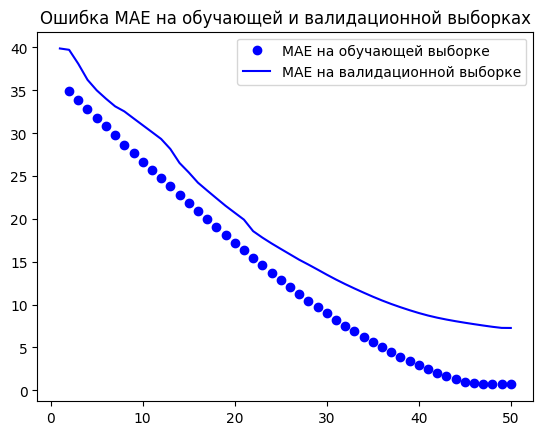

In [95]:
loss = history3.history["mae"]
val_loss = history3.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs[1:], loss[1:], "bo", label="MAE на обучающей выборке")
plt.plot(epochs, val_loss, "b", label="MAE на валидационной выборке")
plt.title("Ошибка MAE на обучающей и валидационной выборках")
plt.legend()
plt.show()

8. Визуализируйте кривые обучения для трех построенных моделей на одном рисунке в зависимости от эпохи обучения, подписывая оси и рисунок и создавая легенду. Используйте для визуализации относительную ошибку (ошибку обучения, деленную на начальную ошибку на первой эпохе). 

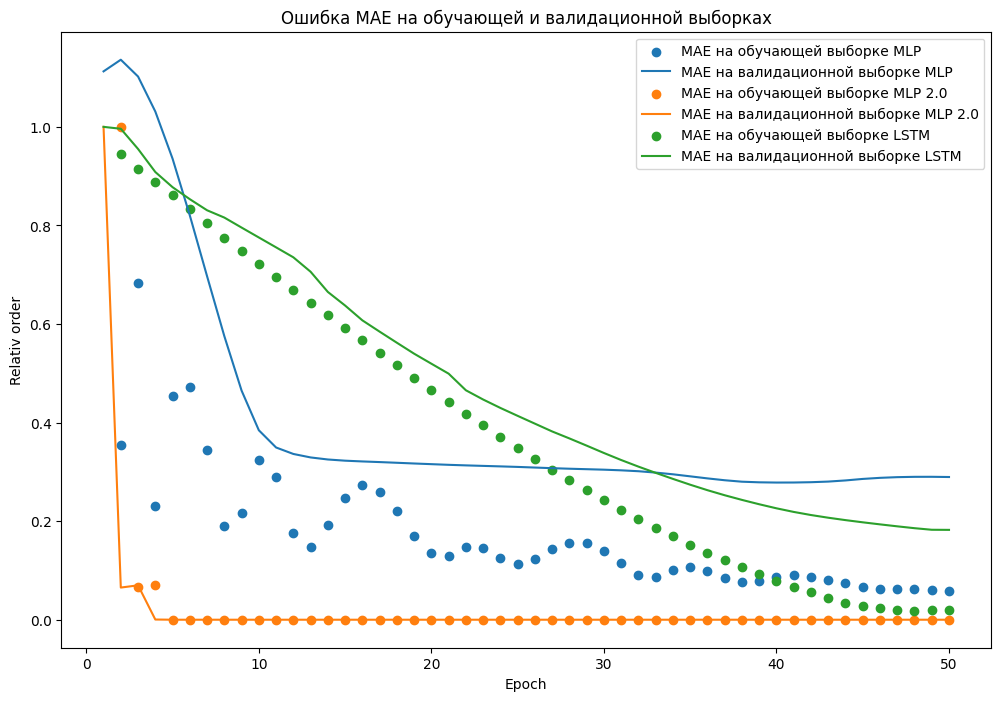

In [98]:
loss1 = np.array(history.history["mae"]) / history3.history["mae"][0]
val_loss1 = np.array(history.history["val_mae"]) / history3.history["val_mae"][0]
loss2 = np.array(history2.history["mae"]) / history2.history["mae"][1]
val_loss2 = np.array(history2.history["val_mae"]) / history2.history["val_mae"][0]
loss3 = np.array(history3.history["mae"]) / history3.history["mae"][0]
val_loss3 = np.array(history3.history["val_mae"]) / history3.history["val_mae"][0]
epochs = range(1, len(loss1) + 1)
plt.figure(figsize=(12,8))
plt.scatter(epochs[1:], loss1[1:], label="MAE на обучающей выборке MLP")
plt.plot(epochs, val_loss1,  label="MAE на валидационной выборке MLP")

plt.scatter(epochs[1:], loss2[1:],  label="MAE на обучающей выборке MLP 2.0")
plt.plot(epochs, val_loss2,  label="MAE на валидационной выборке MLP 2.0")

plt.scatter(epochs[1:], loss3[1:], label="MAE на обучающей выборке LSTM")
plt.plot(epochs, val_loss3, label="MAE на валидационной выборке LSTM")
plt.xlabel('Epoch')
plt.ylabel('Relativ order')
plt.title("Ошибка MAE на обучающей и валидационной выборках")
plt.legend()
plt.show()

9. Визуализируйте весь набор данных и прогнозы трех построенных моделей для обучающей и тестовой выборок на одном рисунке (ось X – даты, ось Y – стоимость акции), подписывая оси и рисунок и создавая легенду.

In [99]:
real = np.array(aapl['Adj Close'])[-191:]

In [100]:
real.shape

(191,)

In [101]:
all_data = tf.keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=adj[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=1000,
    start_index=0)

In [102]:
for a, b in all_data:
  samples = a
  targ = b

In [103]:
y1 = model.predict(samples)
y2 = model2.predict(samples)
y3 = model3.predict(samples)

6/6 [==============================] - 0s 4ms/step


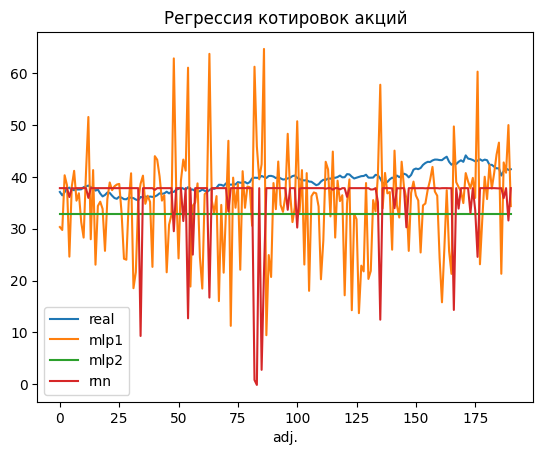

In [104]:
plt.plot(real, label='real')
plt.plot(y1, label='mlp1')
plt.plot(y2, label='mlp2')
plt.plot(y3, label='rnn')
plt.xlabel('day')
plt.xlabel('adj.')
plt.title('Регрессия котировок акций')
plt.legend()